# 00 · Data Overview

Цель ноутбука — проверить структуру сырых данных и зафиксировать первые наблюдения.

## Описание датасета

- Страны: Мексика, Перу, Колумбия; возраст участников 14–61 год, 2 111 записей, собранных через веб-опрос (17 признаков).

  

| Column | Description (EN) | Описание (RU) | Короткое имя (RU) |
| --- | --- | --- | --- |
| **Признаки пищевых привычек** |  |  |  |
| `FAVC` | Frequent consumption of high caloric food | Частое употребление высококалорийной пищи | Жирная еда |
| `FCVC` | Frequency of consumption of vegetables | Частота употребления овощей | Овощи |
| `NCP` | Number of main meals | Количество основных приемов пищи | Приёмы пищи |
| `CAEC` | Consumption of food between meals | Перекусы между приемами пищи | Перекусы |
| `CH2O` | Consumption of water daily | Потребление воды в день | Вода |
| `CALC` | Consumption of alcohol | Употребление алкоголя | Алкоголь |
| **Признаки физического состояния** |  |  |  |
| `SCC` | Calories consumption monitoring | Самоконтроль потребления калорий | Монит. калорий |
| `FAF` | Physical activity frequency | Частота физической активности | Физ. активность |
| `TUE` | Time using technology devices | Время использования электронных устройств | Гаджеты |
| `MTRANS` | Transportation used | Используемый транспорт | Транспорт |
| **Дополнительные переменные** |  |  |  |
| `Gender` | Gender | Пол | Пол |
| `Age` | Age | Возраст | Возраст |
| `Height` | Height | Рост | Рост |
| `Weight` | Weight | Вес | Вес |
| `family_history_with_overweight` | Family history with overweight | История ожирения в семье | Ожирение в семье |
| `SMOKE` | Smoke | Курение | Курение |
| **Целевая переменная** |  |  |  |
| `NObeyesdad` | Obesity level | Уровень ожирения | Уровень ожир. |



**Диапазоны целевой переменной (`NObeyesdad`):**

| Column | Описание (RU) | Диапазон |
| --- | --- | --- |
| `Underweight` | Недостаточный вес | < 18.5 |
| `Normal` | Норма | 18.5–24.9 |
| `Overweight` | Избыточный вес | 25.0–29.9 |
| `Obesity I` | Ожирение I | 30.0–34.9 |
| `Obesity II` | Ожирение II | 35.0–39.9 |
| `Obesity II` | Ожирение III | > 40 |

  

Набор содержит числовые и непрерывные данные, подходит для задач классификации, прогнозирования, сегментации и ассоциаций; исходный файл: CSV.


In [1]:
import math
import pandas as pd
import phik
from IPython.display import Markdown, display
from src.utils import load_csv, load_columns_mapping

import matplotlib.pyplot as plt

# Барчарты для категориальных признаков и гистограмм для числовых

df = load_csv(subdir="raw")
columns_mapping = load_columns_mapping()

# Переименование колонок для отображения (короткие и длинные русские названия)
short_names = {
    column: meta.get("short_ru", column)
    for column, meta in columns_mapping.items()
}
long_names = {
    column: meta.get("description_ru", column)
    for column, meta in columns_mapping.items()
}
df_named = df.rename(columns=short_names)

numeric_df = df.apply(pd.to_numeric, errors="coerce")
numeric = [col for col in df.columns if numeric_df[col].notna().any()]

# Группировка признаков по типам
grouping = {}
for column in df.columns:
    group = columns_mapping.get(column, {}).get("group_ru", "Прочие признаки")
    grouping.setdefault(group, []).append(column)

ordered_groups = [
    "Признаки пищевых привычек",
    "Признаки физического состояния",
    "Дополнительные переменные",
    "Целевая переменная",
]
ordered_groups += [g for g in grouping.keys() if g not in ordered_groups]

display(Markdown("## Графики распределения атрибутов"))

for group in ordered_groups:
    columns = grouping.get(group, [])
    if not columns:
        continue

    n_cols = 3
    n_rows = math.ceil(len(columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for ax, column in zip(axes, columns):
        series = df[column]
        meta = columns_mapping.get(column, {})
        title = long_names.get(column, column)
        ordering = meta.get("order")

        if column in numeric:
            numeric_values = numeric_df[column].dropna()
            ax.hist(numeric_values, bins=20, color="#4C72B0")
        else:
            counts = series.value_counts(dropna=False)
            if ordering:
                categorical_series = pd.Categorical(series, categories=ordering, ordered=True)
                ordered_counts = pd.Series(categorical_series).value_counts(sort=False)
                extra = series[~series.isin(ordering)]
                if not extra.empty:
                    extra_counts = extra.value_counts()
                    ordered_counts = pd.concat([ordered_counts, extra_counts])
            else:
                ordered_counts = counts.sort_values(ascending=False)
            order_labels = ordered_counts.index.astype(str).tolist()
            order_values = ordered_counts.values.tolist()
            positions = list(range(len(order_labels)))
            ax.bar(positions, order_values, color="#55A868")
            ax.set_xticks(positions)
            ax.set_xticklabels(order_labels, rotation=45, ha="right", fontsize=8)
        ax.set_ylabel("Количество")
        ax.set_xlabel("")
        ax.set_title(title)

    for ax in axes[len(columns):]:
        ax.axis("off")

    fig.suptitle(f"{group} — графики распределения атрибутов", y=1.02)
    plt.tight_layout()
    plt.show()



ModuleNotFoundError: No module named 'src'

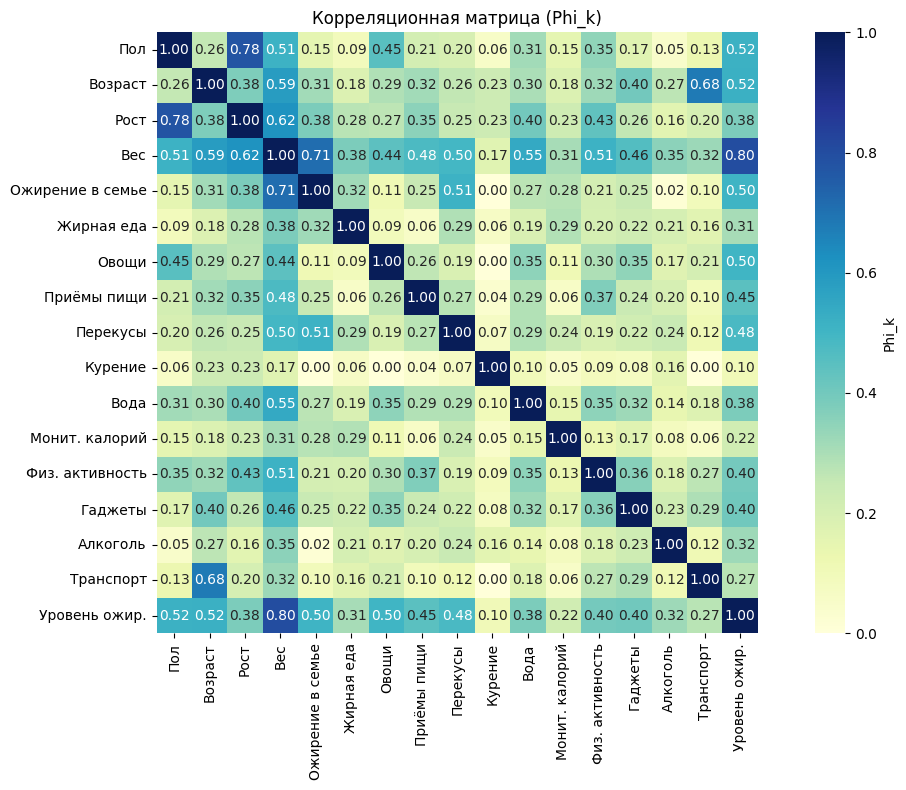

In [ ]:
import seaborn as sns

numeric_short_columns = df_named.select_dtypes(include=["number"]).columns.tolist()
phik_matrix = df_named.phik_matrix(interval_cols=numeric_short_columns)

plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    square=True,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Phi_k"},
)
plt.title("Корреляционная матрица (Phi_k)")
plt.tight_layout()
plt.show()



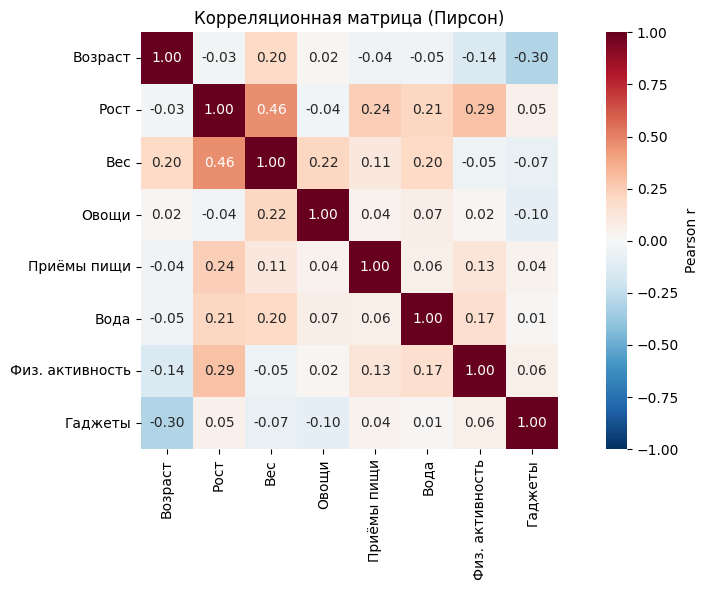

In [ ]:
import seaborn as sns

numeric_only = df_named.apply(pd.to_numeric, errors="coerce")
numeric_only = numeric_only.dropna(axis=1, how="all")
pearson_corr = numeric_only.corr(method="pearson")

plt.figure(figsize=(10, 6))
sns.heatmap(
    pearson_corr,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("Корреляционная матрица (Пирсон)")
plt.tight_layout()
plt.show()
